In [ ]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=016f4ac1ff76eed35aa8f728cd777e9d6e4e3c8322ac2323a635173c14a6bd96
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import KBinsDiscretizer
import ta

In [ ]:
seq_length = 64
d_model = 16
nhead = 4
num_layers = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

shuffle = True

batch_size = 32

In [ ]:
# Define your stock and data parameters
stock = '^GSPC'

def get_stock(stock_choice):
    start, end = '', ''
    if stock_choice == '^GSPC':
        start = '1980-01-01'
        end = '2024-08-10'
    elif stock_choice == 'AAPL':
        start = '1984-12-12'
        end = '2024-08-10'
    elif stock_choice == '^DJI':
        start = '1980-01-01'
        end = '2024-08-10'
    elif stock_choice == 'PFE':
        start = '1980-01-01'
        end = '2024-08-10'
    elif stock_choice == 'GOOGL':
        start = '2004-08-19'
        end = '2024-08-10'
    elif stock_choice == 'TSLA':
        start = '2010-06-29'
        end = '2024-08-10'
    else:
        start = '2010-01-01'
        end = '2024-08-10'

    return start, end

start, end = get_stock(stock)

# Download stock data
yfd = yf.download(stock, start=start, end=end)

def calculate_obv(data):
    """Calculate On-Balance Volume (OBV)."""
    obv = [0]  # Initialize OBV with the first value as 0
    for i in range(1, len(data)):
        if data['Close'].iloc[i] > data['Close'].iloc[i - 1]:
            obv.append(obv[-1] + data['Volume'].iloc[i])
        elif data['Close'].iloc[i] < data['Close'].iloc[i - 1]:
            obv.append(obv[-1] - data['Volume'].iloc[i])
        else:
            obv.append(obv[-1])
    return pd.Series(obv, index=data.index)

# Assuming 'yfd' is your DataFrame with 'Close' and 'Volume' columns
yfd['OBV'] = calculate_obv(yfd)

# Calculate maximum range over the last n days
n = 3  # Adjust this as needed
yfd['Max_Range'] = yfd['High'].rolling(window=n).max() - yfd['Low'].rolling(window=n).min()

# Calculate percent change for closing price
yfd['Percent_Change'] = yfd['Close'].pct_change()

# Calculate RSI (14-day by default)
yfd['RSI'] = ta.momentum.RSIIndicator(yfd['Close'], window=14).rsi()

# Select features to include: Percent Change, Volume, Max Range, and RSI
features = ['Percent_Change', 'Volume', 'Max_Range', 'RSI', 'OBV']
df = yfd[features].dropna()

# Normalize the data
std = df.std()
mean = df.mean()

normalized_data = (df - mean) / std

print(normalized_data.head())

# Create sequences
sequences = []
for i in range(len(normalized_data) - seq_length):
    sequences.append(normalized_data[i:i + seq_length].values)

sequences = np.array(sequences)

# Create sequences
X = []
y = []

for i in range(len(normalized_data) - seq_length - 1):
    X.append(normalized_data.iloc[i:i + seq_length].values)
    y.append(normalized_data['Percent_Change'].iloc[i + seq_length])  # Predicting the next day's percent change

X = np.array(X)
y = np.array(y)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)  # Ensure y is a 2D tensor for compatibility

# Create original indices
original_indices = np.arange(len(X_tensor))

# Split data
x_train, x_temp, y_train, y_temp, train_indices, temp_indices = train_test_split(
    X_tensor, y_tensor, original_indices, test_size=0.3, random_state=42, shuffle=True)

x_val, x_test, y_val, y_test, val_indices, test_indices = train_test_split(
    x_temp, y_temp, temp_indices, test_size=0.5, random_state=42, shuffle=False)

# Create TensorDatasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

# Create DataLoaders
batch_size = 32  # Adjust this as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

[*********************100%***********************]  1 of 1 completed


            Percent_Change    Volume  Max_Range       RSI       OBV
Date                                                               
1980-01-21        0.787178 -1.000826  -0.749834  2.959980 -0.806687
1980-01-22       -0.503653 -0.999471  -0.746347  2.134083 -0.806794
1980-01-23        1.500628 -0.999413  -0.745005  2.632309 -0.806686
1980-01-24        0.167227 -0.995033  -0.716032  2.682630 -0.806561
1980-01-25       -0.106579 -1.001319  -0.716300  2.578558 -0.806661


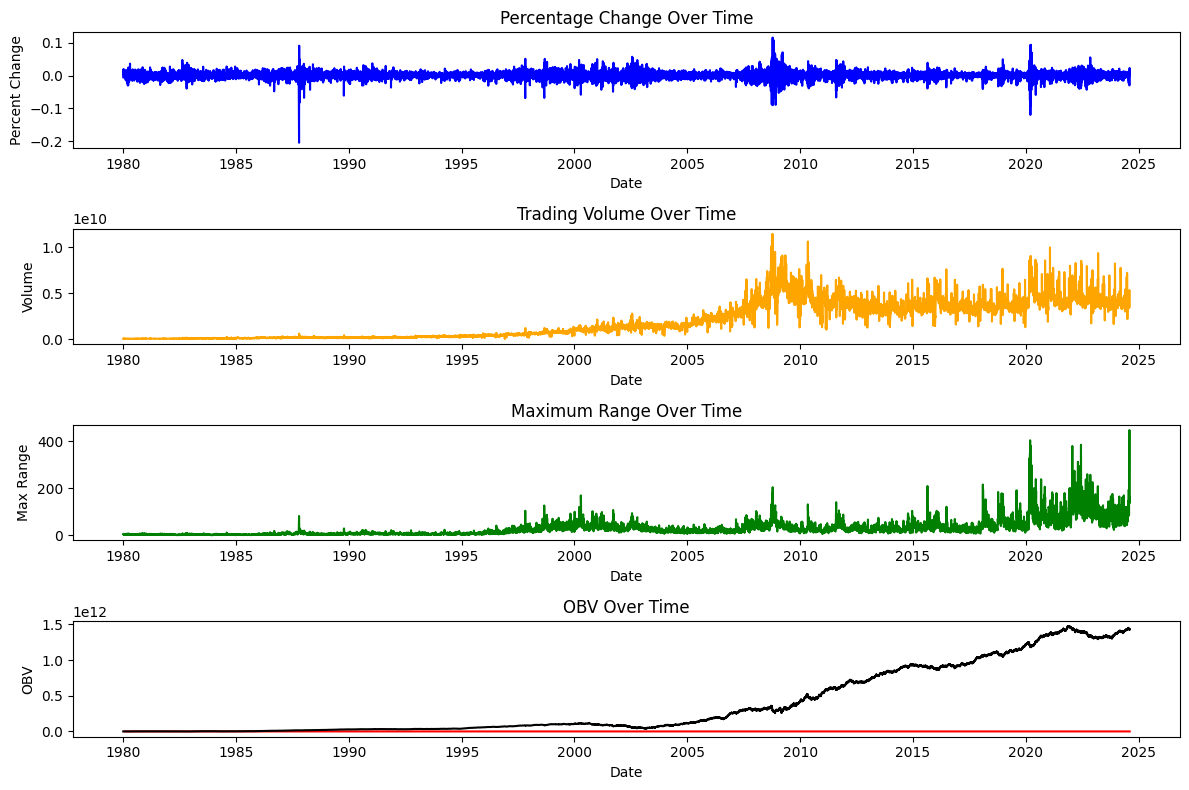

In [ ]:
# Set the figure size for all plots
plt.figure(figsize=(12, 8))

# Plot Percentage Change
plt.subplot(4, 1, 1)
plt.plot(yfd.index, yfd['Percent_Change'], color='blue')
plt.title('Percentage Change Over Time')
plt.xlabel('Date')
plt.ylabel('Percent Change')

# Plot Trading Volume
plt.subplot(4, 1, 2)
plt.plot(yfd.index, yfd['Volume'], color='orange')
plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')

# Plot Maximum Range
plt.subplot(4, 1, 3)
plt.plot(yfd.index, yfd['Max_Range'], color='green')
plt.title('Maximum Range Over Time')
plt.xlabel('Date')
plt.ylabel('Max Range')

# Plot RSI
plt.subplot(4, 1, 4)
plt.plot(yfd.index, yfd['RSI'], color='red')
plt.title('RSI Over Time')
plt.xlabel('Date')
plt.ylabel('RSI')

# Plot OBV
plt.subplot(4, 1, 4)
plt.plot(yfd.index, yfd['OBV'], color='black')
plt.title('OBV Over Time')
plt.xlabel('Date')
plt.ylabel('OBV')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Add a batch dimension
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]  # Broadcast along the batch size
        return x

class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, seq_length, num_bins):
        super(TransformerModel, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=seq_length)

        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)

        # Adjust the final output layer to predict bins
        self.fc_out = nn.Linear(d_model * seq_length, num_bins)

    def forward(self, src):
        src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)

        # Flatten the output from transformer encoder to feed into the final linear layer
        output = output.view(output.size(0), -1)
        output = self.fc_out(output).float()  # Keep as raw logits
        return output


In [ ]:
# Define model parameters
input_dim = X_tensor.shape[2]  # Number of features, now 3 with the addition of Max_Range
d_model = 64  # Dimension of the model
nhead = 64  # Number of attention heads
num_encoder_layers = 2  # Number of encoder layers
dim_feedforward = 128  # Dimension of the feedforward network
seq_length = X_tensor.shape[1]  # Sequence length
output_dim = 1  # Predicting a single continuous value (percent change)

model = TransformerModel(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, seq_length, output_dim).to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
class DirectionalMSELoss(nn.Module):
    def __init__(self, base_loss=nn.MSELoss(), reward_scale=0.8):
        super(DirectionalMSELoss, self).__init__()
        self.base_loss = base_loss
        self.reward_scale = reward_scale

    def forward(self, predictions, targets):
        # Base MSE loss
        mse_loss = self.base_loss(predictions, targets)

        # Calculate the sign of predictions and targets (1 for positive, -1 for negative)
        pred_direction = torch.sign(predictions)
        target_direction = torch.sign(targets)

        # Calculate directional accuracy (1 if directions match, 0 otherwise)
        directional_accuracy = (pred_direction == target_direction).float()

        # Apply the reward: scale down the loss if the direction is correct
        reward_factor = 1.0 - self.reward_scale * directional_accuracy

        # Final loss: MSE loss scaled by the reward factor
        final_loss = mse_loss * reward_factor

        # Return the mean of the final loss
        return final_loss.mean()

epochs = 128
criterion = DirectionalMSELoss()  # Use Mean Squared Error loss for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Clear the gradients

        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters
        running_loss += loss.item()  # Accumulate loss

    average_train_loss = running_loss / len(train_loader)
    print(f"[{epoch+1}/{epochs}, {average_train_loss:.4f}", end='')

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:

            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    average_val_loss = val_loss / len(val_loader)
    print(f", {average_val_loss:.4f}]")


[1/128, 0.3416, 0.6854]


KeyboardInterrupt: 

Test Loss (MSE): 1.4875
Test MAE: 0.8070


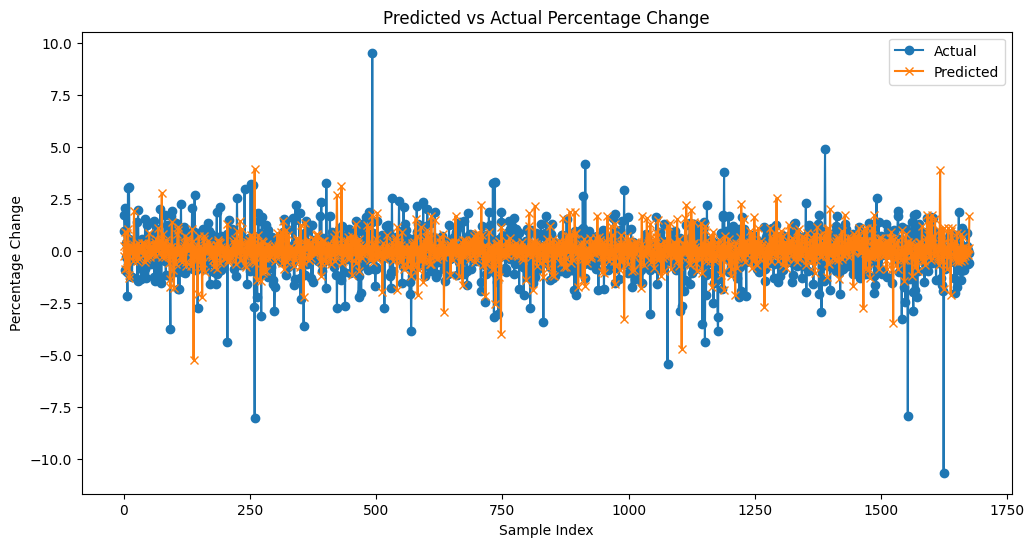

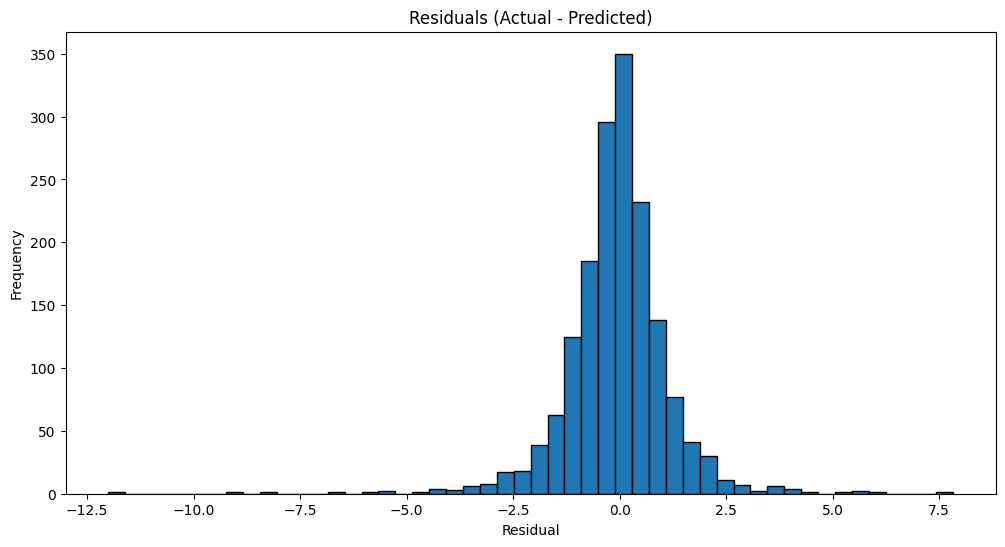

In [ ]:
def evaluate_model(model, data_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)  # Forward pass

            loss = criterion(outputs, targets)  # Calculate loss
            total_loss += loss.item()

            # Collect targets and predictions for visualization
            all_targets.extend(targets.cpu().numpy().flatten())
            all_predictions.extend(outputs.cpu().numpy().flatten())

    # Calculate average loss
    average_loss = total_loss / len(data_loader)

    # Calculate additional metrics
    mse = mean_squared_error(all_targets, all_predictions)
    mae = mean_absolute_error(all_targets, all_predictions)

    return average_loss, mse, mae, all_predictions, all_targets

# Evaluate on the test set
test_loss, test_mse, test_mae, all_predictions, all_targets = evaluate_model(model, test_loader, criterion)

print(f"Test Loss (MSE): {test_mse:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# Plotting Predictions vs. Actual Values
plt.figure(figsize=(12, 6))
plt.plot(all_targets, label='Actual', marker='o')
plt.plot(all_predictions, label='Predicted', marker='x')
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Percentage Change')
plt.title('Predicted vs Actual Percentage Change')
plt.show()

# Plotting Residuals
residuals = np.array(all_targets) - np.array(all_predictions)
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=50, edgecolor='black')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residuals (Actual - Predicted)')
plt.show()

Test Loss (MSE): 0.3409
Test MAE: 0.4299


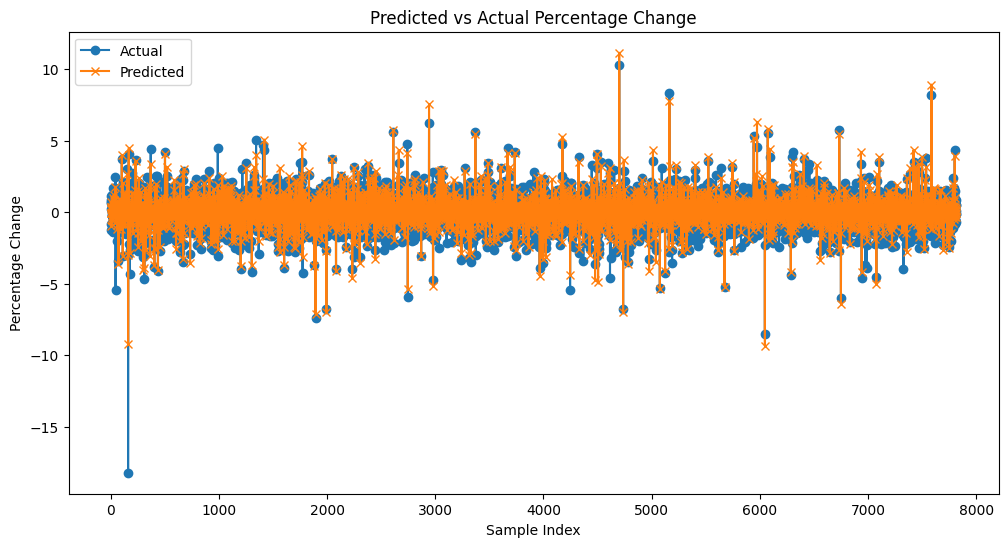

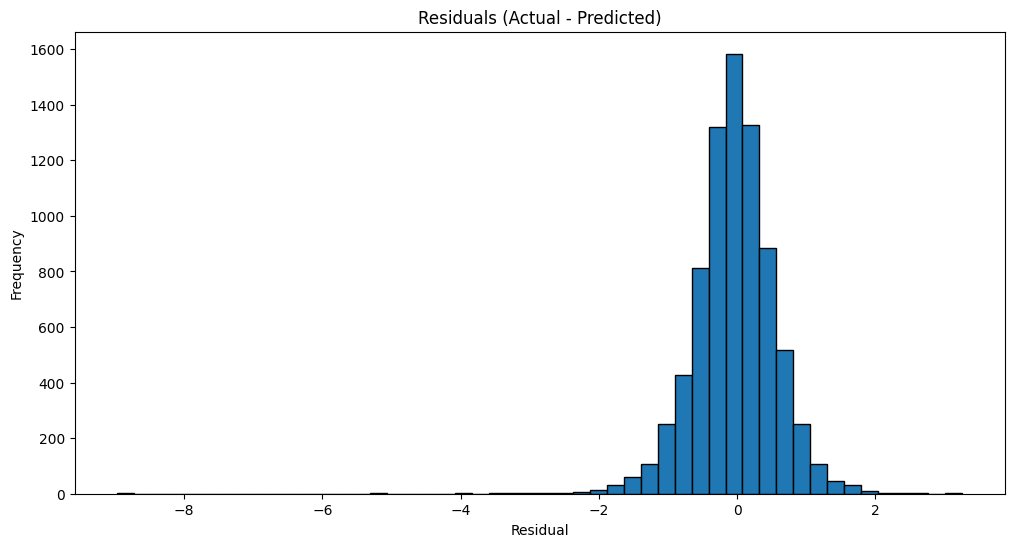

In [ ]:
# Evaluate on the test set
test_loss, test_mse, test_mae, all_predictions, all_targets = evaluate_model(model, train_loader, criterion)

print(f"Test Loss (MSE): {test_mse:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# Plotting Predictions vs. Actual Values
plt.figure(figsize=(12, 6))
plt.plot(all_targets, label='Actual', marker='o')
plt.plot(all_predictions, label='Predicted', marker='x')
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Percentage Change')
plt.title('Predicted vs Actual Percentage Change')
plt.show()

# Plotting Residuals
residuals = np.array(all_targets) - np.array(all_predictions)
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=50, edgecolor='black')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residuals (Actual - Predicted)')
plt.show()